In [1]:
import numpy as np
import torch

from default_params import default_params

import sys
sys.path.append('..')
from rnn.dms_task import DMS
from rnn.utils import *
from rnn.train import *
from rnn.model import RNN

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)

### We first initialize dictionaries to keep track of model, task and training parameters

In [2]:
model_params, training_params, task_params = default_params()
model_params['apply_dale']=False
model_params['spectr_rad']=0.75

### Initialize an RNN

In [3]:
rnn = RNN(model_params)


spectral_rad: 0.75


### Plot the weight matrix
We first initialize the network in the non-chaotic regime, and then add a low-rank perturbation to create oscillations

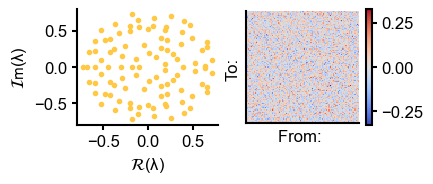

In [4]:
with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn.rnn.w_rec.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)

### Low rank perturbation

This rank 2 perturbation adds complex conjugate outliers 
Mastrogiueseppe & Ostojic 2018, https://www.sciencedirect.com/science/article/pii/S0896627318305439)

Alternative is a correlated rank 1 perturbation 
Schuessler et all. 2020, https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.013111

Or only imaginary eigenvalues
Chang et al. 2019, https://openreview.net/forum?id=ryxepo0cFX


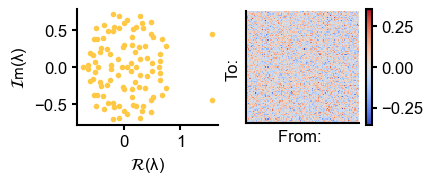

In [5]:
w=1.4
sd=3
dg=4
N=100

covariance_matrix=np.array([
    [dg,0,sd,-w],
    [0,dg,w,sd],
    [sd,w,dg,0],
    [-w,sd,0,dg],
])

loadings = np.random.randn(N,4)@np.linalg.cholesky(covariance_matrix)/np.sqrt(N)
n1=loadings[:,0]
n2=loadings[:,1]
m1=loadings[:,2]
m2=loadings[:,3]

perturbation = np.outer(n1,m1)+np.outer(n2,m2)
with torch.no_grad():
    rnn.rnn.w_rec.copy_(rnn.rnn.w_rec+torch.from_numpy(perturbation))

with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn.rnn.conn_mask(rnn.rnn.dale_mask(rnn.rnn.w_rec))
    w_eff = w_eff.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)

### Plot example rates

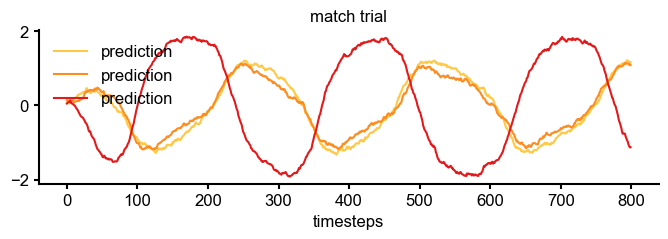

In [6]:
rates, pred = predict(rnn, torch.zeros(800,2))

with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(figsize=(8, 2))
    axs.set_title("match trial")
    axs.plot(rates[0,:,::40], label="prediction")
    axs.legend()
    axs.set_xlabel("timesteps")


### Plot trajectories projected on first three PCs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


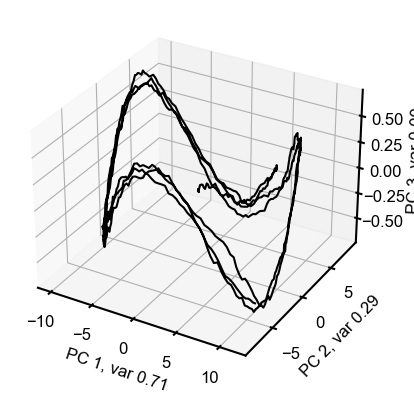

In [7]:
z, varexp = PC_traj(rates, n_comp=3)
with mpl.rc_context(fname="matplotlibrc"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(z[0, :, 0], z[0, :, 1], z[0, :, 2], color="black")

    ax.set_xlabel("PC 1, var {:.2f}".format(varexp[0]))
    ax.set_ylabel("PC 2, var {:.2f}".format(varexp[1]))
    ax.set_zlabel("PC 3, var {:.2f}".format(varexp[2]))
    plt.legend()
    plt.show()

### We can also regularize an RNN to exhibit oscillatory activity
This does require training, as opposed to the previous methods. We could also simply setup a task in which the network has to produce a sine wave of specific frequency ;)

In [8]:
model_params, training_params, task_params = default_params()
training_params["osc_reg_cost"] = 5
training_params["osc_reg_freq"] = 3
training_params['cuda']=False
dms = DMS(task_params)

rnn_osc = RNN(model_params)
losses, reg_losses = train_rnn(rnn_osc, training_params, dms, sync_wandb=False)

spectral_rad: 1.0
epoch 500 / 500: time=24.6 s, task loss=0.00883, reg loss=0.25315
Done. Training took 24.6 sec.


In [9]:
s, t, m = dms[0]


rates, pred = predict(rnn_osc, s, mse_loss, t, m)

LFP = (
    extract_lfp(torch.from_numpy(rates), rnn.rnn, normalize=False)
    .cpu()
    .detach()
    .numpy()
)

freqs_l = np.logspace(*np.log10([1, 10]), num=50)
dt_sec = model_params["dt"] / 1000
tm = np.arange(0, dms.trial_len() * dt_sec, dt_sec)
_, amp = scalogram(
    LFP[0],
    7,
    tm,
    dt_sec,
    freqs_l,
)

test loss: 0.007951389066874981


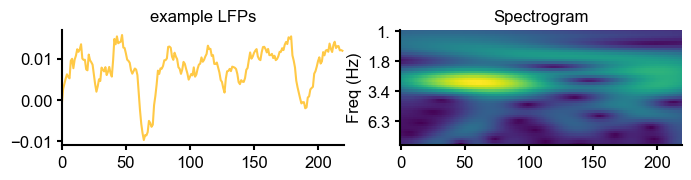

In [10]:
with mpl.rc_context(fname="matplotlibrc"):

    fig, axs = plt.subplots(1, 2, figsize=(8, 1.5))
    axs[0].set_title("example LFPs")
    axs[0].plot(LFP.T)
    axs[0].set_xlim(0, dms.trial_len())

    axs[1].set_title("Spectrogram")
    axs[1].imshow(amp, aspect="auto")
    axs[1].set_yticks(np.arange(0, len(freqs_l))[::13])
    axs[1].set_yticklabels(["{:.1f}".format(f).strip("0") for f in freqs_l[::13]])
    axs[1].set_ylabel("Freq (Hz)")

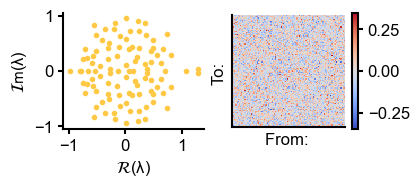

In [13]:
with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn_osc.rnn.conn_mask(rnn_osc.rnn.dale_mask(rnn_osc.rnn.w_rec))
    w_eff = w_eff.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)